MIDTERM APP #2 - TRAFFIC VOLUME PREDCITION 

In [1]:
# IMPORT LIBRARIES

import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

import sklearn

# Package to implement ML Algorithms
import xgboost
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

LOAD DATASET

In [2]:
df = pd.read_csv('Traffic_Volume.csv')

df.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main      date_time  \
0     NaN  288.28      0.0      0.0          40       Clouds   10/2/12 9:00   
1     NaN  289.36      0.0      0.0          75       Clouds  10/2/12 10:00   
2     NaN  289.58      0.0      0.0          90       Clouds  10/2/12 11:00   
3     NaN  290.13      0.0      0.0          90       Clouds  10/2/12 12:00   
4     NaN  291.14      0.0      0.0          75       Clouds  10/2/12 13:00   

   traffic_volume  
0            5545  
1            4516  
2            4767  
3            5026  
4            4918

SELECT INPUT AND OUTPUT VARIABLES AND CREATE DUMMY VARIABLES FOR TRAINING

In [3]:
# Convert the 'date_time' column to month, weekday, hour
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y %H:%M')

# Extract specific month, day, hour and add to dataframe as new column
df['month'] = df['date_time'].dt.month_name()       # Month name
df['weekday'] = df['date_time'].dt.day_name()   # Day name 
df['hour'] = df['date_time'].dt.hour                # Hour (0-23)

# Define input and output features
x = df.drop(columns=['date_time','traffic_volume'])
y = df['traffic_volume']

x.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main    month  \
0     NaN  288.28      0.0      0.0          40       Clouds  October   
1     NaN  289.36      0.0      0.0          75       Clouds  October   
2     NaN  289.58      0.0      0.0          90       Clouds  October   
3     NaN  290.13      0.0      0.0          90       Clouds  October   
4     NaN  291.14      0.0      0.0          75       Clouds  October   

   weekday  hour  
0  Tuesday     9  
1  Tuesday    10  
2  Tuesday    11  
3  Tuesday    12  
4  Tuesday    13

CREATE DUMMIES

In [4]:
# One hot encoding for categorical variables
x_encoded = pd.get_dummies(x)
x_encoded.head()

temp  rain_1h  snow_1h  clouds_all  hour  holiday_Christmas Day  \
0  288.28      0.0      0.0          40     9                  False   
1  289.36      0.0      0.0          75    10                  False   
2  289.58      0.0      0.0          90    11                  False   
3  290.13      0.0      0.0          90    12                  False   
4  291.14      0.0      0.0          75    13                  False   

   holiday_Columbus Day  holiday_Independence Day  holiday_Labor Day  \
0                 False                     False              False   
1                 False                     False              False   
2                 False                     False              False   
3                 False                     False              False   
4                 False                     False              False   

   holiday_Martin Luther King Jr Day  ...  month_November  month_October  \
0                              False  ...           False           True   
1                              False  ...           False           True   
2                              False  ...           False           True   
3                              False  ...           False           True   
4                              False  ...           False           True   

   month_September  weekday_Friday  weekday_Monday  weekday_Saturday  \
0            False           False           False             False   
1            False           False           False             False   
2            False           False           False             False   
3            False           False           False             False   
4            False           False           False             False   

   weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  
0           False             False             True              False  
1           False             False             True              False  
2           False             False             True              False  
3           False             False             True              False  
4           False             False             True              False  

[5 rows x 46 columns]

In [5]:
# Data partitioning into train and test sets
train_x, test_x, train_y, test_y = train_test_split(x_encoded, y, test_size = 0.3, random_state = 42)




IMPLEMENT XG BOOST ALGORITHM

In [6]:
# create model instance
bst = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, objective='reg:squarederror', random_state = 42)


In [7]:
# Fit the model
start = time.time()            # Start Time
bst.fit(train_x, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.6420247554779053s


EVALUATE PERFORMANCE USING TEST DATA 

In [8]:
# Predict Test Set
y_pred = bst.predict(test_x)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 444.12


GENERATE PLOTS

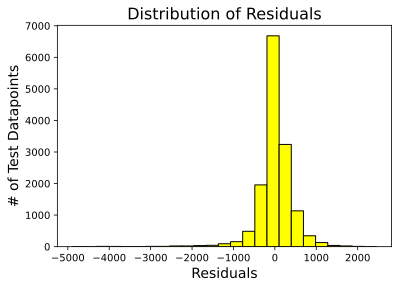

In [9]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'yellow', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

# Save the plot as an SVG file
plt.savefig("residual_plot.svg", format="svg")

In [10]:
# SCATTER PLOT

# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Traffic Volume', fontsize = 10)
plt.ylabel('Predicted Traffic Volume', fontsize = 10)
plt.title('Predicted vs Actual Traffic Volume', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

# Save the plot as an SVG file
plt.savefig("pred_vs_actual.svg", format="svg")

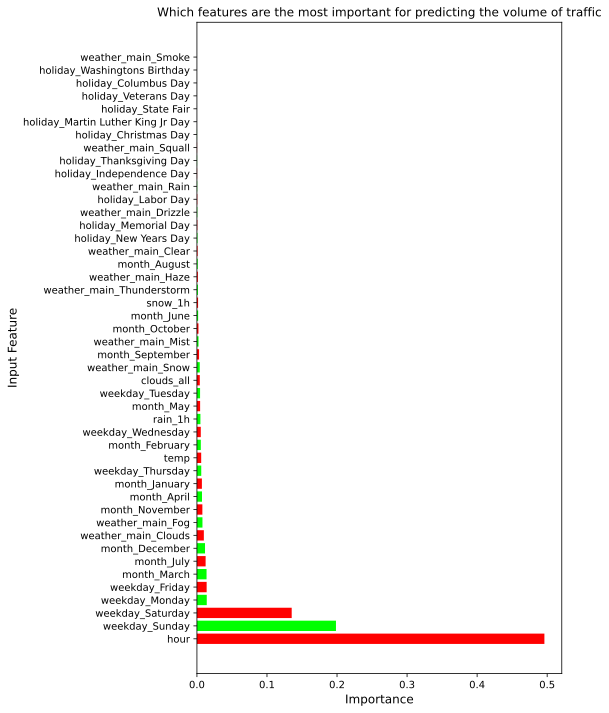

In [11]:
# FEATURE IMPORTANCE

# Storing importance values from the trained model
importance = bst.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 10))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting the volume of traffic', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

# Save the plot as an SVG file
plt.savefig("feature_imp.svg", format="svg")

PREDICTION INTERVALS USING MAPIE REGRESSSOR

In [12]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = bst, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_x, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_x, alpha = alpha)

Training time: 9.527528285980225s


In [13]:
# Predicted values
y_test_pred

array([5830.9194 , 2401.3616 ,  707.01465, ...,  386.42444,  441.4774 ,
       4638.667  ], dtype=float32)

In [14]:
# Prediction Intervals
y_test_pis

array([[[5205.91357422],
        [6406.5390625 ]],

       [[1784.65942383],
        [2987.29760742]],

       [[  98.90167236],
        [1294.72625732]],

       ...,

       [[-202.84191895],
        [ 992.93457031]],

       [[-187.89474487],
        [1010.87615967]],

       [[4042.87158203],
        [5251.65869141]]])

In [15]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Traffic Volume']
predictions["Predicted Traffic Volume"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

Actual Traffic Volume  Predicted Traffic Volume  Lower Value  \
31666                   4043               3332.570068      2754.39   
8482                    1036                876.419983       309.47   
46938                    381                386.420013      -202.84   
1719                     264                441.480011      -187.89   
30487                   4304               4638.669922      4042.87   

       Upper Value  
31666      3958.40  
8482       1505.50  
46938       992.93  
1719       1010.88  
30487      5251.66

In [16]:
# Coverage Calculation

coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 90.84%


In [17]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Traffic Volume']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Traffic Volume"], 'go', markersize=3, label="Actual Traffic Volume")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

# Save the plot as an SVG file
plt.savefig("coverage.svg", format="svg")

SAVE MODEL TO PICKLE FILE

In [18]:
# Creating the file where we want to write the model
xgboost_pickle = open('xgboost_traffic_volume.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, xgboost_pickle) 

# Close the file
xgboost_pickle.close()